# Generative Adversarial Nets

Training a generative adversarial network to sample from a Gaussian distribution

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
%matplotlib inline

### Geneate target distribution $p_{data}$

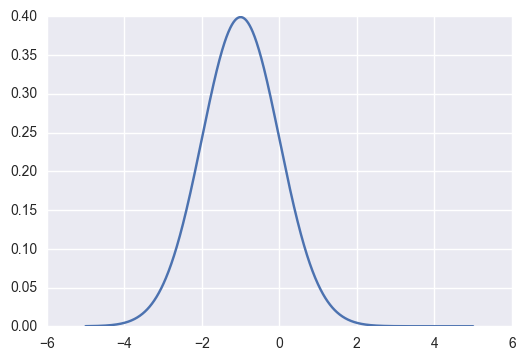

In [2]:
mu = -1.0
sigma = 1.0
xs = np.linspace(-5, 5, 1000)
plt.plot(xs, norm.pdf(xs, loc=mu, scale=sigma))
# Plot the target distribution

### The Preparation (MLP Model and Optimizer)

In [3]:
train_epochs = 10000
batch_size = 200

In [4]:
# MLP Model
def mlp(input_tensor, out_dim):
    """
    Construct a mlp model 
    :param input_tensor: 2-D tensor
    :param out_dim: int, the dimension of the output
    """
    in_dim = input_tensor.get_shape().as_list()[-1]
    W0 = tf.get_variable("W0", [in_dim, 6], initializer=tf.random_normal_initializer())
    b0 = tf.get_variable("b0", [6, ], initializer=tf.constant_initializer(0.0))
    W1 = tf.get_variable("W1", [6, 5], initializer=tf.random_normal_initializer())
    b1 = tf.get_variable("b1", [5, ], initializer=tf.constant_initializer(0.0))
    W2 = tf.get_variable("W2", [5, out_dim], initializer=tf.random_normal_initializer())
    b2 = tf.get_variable("b2", [out_dim, ], initializer=tf.constant_initializer(0.0))
    # Use tanh activation function 
    fc0 = tf.nn.tanh(tf.nn.xw_plus_b(input_tensor, W0, b0))
    fc1 = tf.nn.tanh(tf.nn.xw_plus_b(fc0, W1, b1))
    output = tf.nn.tanh(tf.nn.xw_plus_b(fc1, W2, b2))
    return output, [W0, b0, W1, b1, W2, b2]

In [5]:
# Use monmentum optimizer for training
def momentum_optimizer(loss, var_list):
    """
    Return the train operation by defining monmentum optimizer
    """
    global_step = tf.Variable(0, trainable=False)
    lr = tf.train.exponential_decay(0.001, global_step, decay_steps=train_epochs//4, 
                                    decay_rate=0.95, staircase=True)
    train_op = tf.train.MomentumOptimizer(lr, 0.6).minimize(loss, global_step=global_step,
                                                            var_list=var_list)
    return train_op

## Pre-train Discriminative Model ($D$)
We firstly pre-train the discriminative model for faster convergence

In [6]:
with tf.variable_scope("D_pre"):
    input = tf.placeholder(tf.float32, shape=[batch_size, 1])
    target = tf.placeholder(tf.float32, shape=[batch_size, 1])
    D, param_D = mlp(input, 1)
    loss = tf.reduce_mean(tf.square(D - target))

In [7]:
train_op = momentum_optimizer(loss, param_D)

In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [9]:
# Ploter for decision surface
def ploter_d0(D, input):
    f, ax = plt.subplots(1)
    # Get p_data
    xs = np.linspace(-5, 5, 1000)
    ax.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label="p_data")
    # Plot the decision surface
    r = 1000 # number of points
    xs = np.linspace(-5, 5, r)
    ds = np.zeros(r)
    # Get the decision surface 
    for i in range(r//batch_size):
        x = np.reshape(xs[batch_size*i:batch_size*(i+1)], [batch_size, 1])
        ds[batch_size*i:batch_size*(i+1)] = np.reshape(sess.run(D, feed_dict={input: x}), [-1])
    ax.plot(xs, ds, label="decision boundary")
    ax.set_ylim(0, 1.2)
    plt.legend()

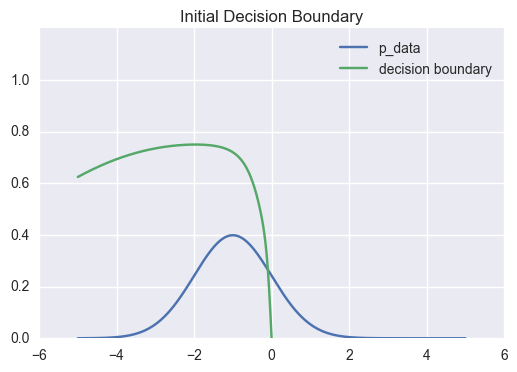

In [10]:
ploter_d0(D, input)
plt.title("Initial Decision Boundary")

In [11]:
# Pre-train D
losses = np.zeros(1000)
for i in range(1000):
    x = (np.random.random(batch_size) - 0.5)*10.0  # to ensure the data equally distributed
    y = norm.pdf(x, loc=mu, scale=sigma)
    l, _ = sess.run([loss, train_op], feed_dict={input:np.reshape(x, [batch_size,1]),
                                                target:np.reshape(y, [batch_size, 1])})
    losses[i] = l

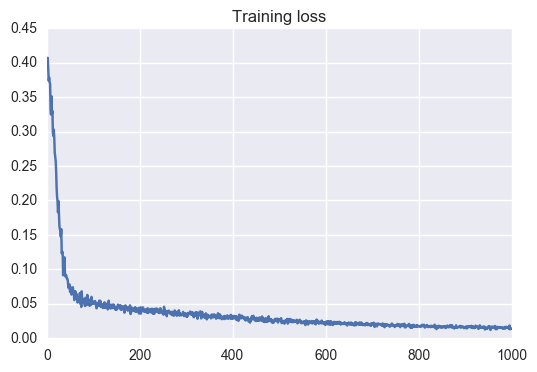

In [12]:
# Plot the training lossses
plt.plot(losses)
plt.title("Training loss")

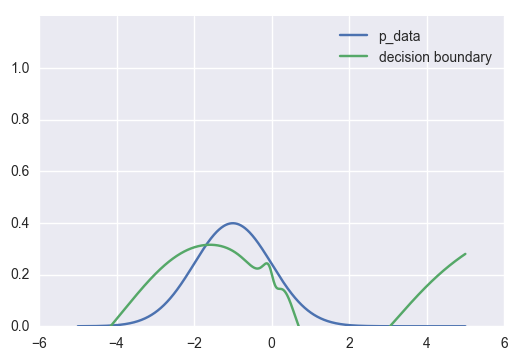

In [13]:
ploter_d0(D, input)

In [14]:
# Save the pretrained parameters to reuse
D_pre_params = sess.run(param_D)

In [15]:
sess.close()

## Construct GAN Model

In [16]:
# G Model
with tf.variable_scope("G"):
    z_tensor = tf.placeholder(tf.float32, shape=[batch_size, 1])
    G, param_G = mlp(z_tensor, 1)
    G = tf.mul(G, 5.0)  # scaling
# D model to take x as input
with tf.variable_scope("D", reuse=None):
    x_tensor = tf.placeholder(tf.float32, shape=[batch_size, 1])
    D1, param_D = mlp(x_tensor, 1)
    # Clips values to a specified min and max
    D1 = tf.clip_by_value(D1, 0.01, 0.99)
# D model to take D(z) as input
with tf.variable_scope("D", reuse=True):
    D2, param_D = mlp(G, 1)
    D2 = tf.clip_by_value(D2, 0.01, 0.99)
# The objective function of G and D model
obj_D = tf.reduce_mean(tf.log(D1) + tf.log(1-D2))
obj_G = tf.reduce_mean(tf.log(D2))
# The train operations of G and D model
train_op_D = momentum_optimizer(1.0 - obj_D, param_D)
train_op_G = momentum_optimizer(1.0 - obj_G, param_G)

In [50]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
tf.set_random_seed(1234)
# Load the pre-trained parameters
for v, p in zip(D_pre_params, param_D):
    sess.run(tf.assign(p, v))

In [29]:
# The ploter 
def ploter_g_d():
    """Plot the p_data, p_G and decision boundary"""
    f, ax = plt.subplots(1)
    # p_data
    xs = np.linspace(-5, 5, 1000)
    ax.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label="p_data")
    # decision boundary
    r = 5000
    xs = np.linspace(-5, 5, r)
    ds = np.zeros(r)
    for i in range(r//batch_size):
        x = np.reshape(xs[batch_size*i:batch_size*(i+1)], [batch_size, 1])
        ds[batch_size*i:batch_size*(i+1)] = np.reshape(sess.run(D1, feed_dict={x_tensor:x}), [-1])
    ax.plot(xs, ds, label="decision boundary")
    
    # Plot the generated distribution by G model
    zs = np.linspace(-5, 5, r)
    gs = np.zeros(r)
    for i in range(r//batch_size):
        z = np.reshape(zs[batch_size*i:batch_size*(i+1)], [batch_size, 1])
        gs[batch_size*i:batch_size*(i+1)] = np.reshape(sess.run(G, feed_dict={
                    z_tensor:z }), [-1])
    histc, _ = np.histogram(gs, bins=20, density=True)
    ax.plot(np.linspace(-5, 5, 20), histc, label="p_g")
    
    ax.set_ylim(0.0, 1.2)
    plt.legend()

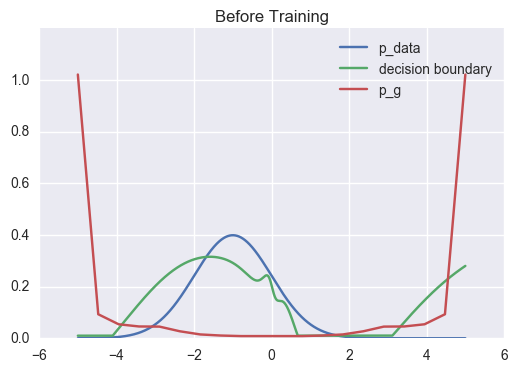

In [51]:
# Before training
ploter_g_d()
plt.title("Before Training")

In [52]:
# Train the GAN
np.random.seed(2017)
k = 1 # The training steps of D
# Keep track of the objectives
fs_D, fs_G = np.zeros(train_epochs), np.zeros(train_epochs)
for i in range(train_epochs):
    # Train D
    for j in range(k):
        x = np.random.normal(mu, sigma, size=batch_size)
        x.sort()
        z = np.linspace(-5, 5, batch_size) + np.random.random(batch_size)*0.01
        fs, _ = sess.run([obj_D, train_op_D], feed_dict={x_tensor: np.reshape(x, [batch_size, 1]),
                                             z_tensor: np.reshape(z, [batch_size, 1])})
    fs_D[i] = fs    
    # Train G
    z = np.linspace(-5, 5, batch_size) + np.random.random(batch_size)*0.01
    fs_G[i], _ = sess.run([obj_G, train_op_G], feed_dict={z_tensor: np.reshape(z, [batch_size, 1])})
print("Finished")

Finished


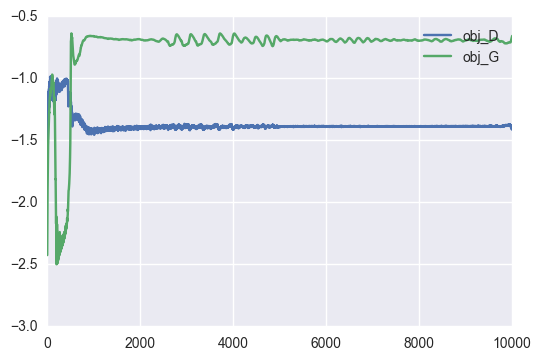

In [53]:
# Plot the objectives
plt.plot(fs_D, label="obj_D")
plt.plot(fs_G, label="obj_G")
plt.legend()

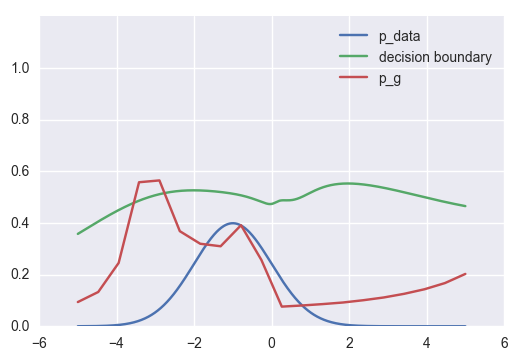

In [54]:
ploter_g_d()